참고 (딥러닝을 이용한 자연어 처리)
: https://wikidocs.net/94600

위 링크에는 keras framework로 신경망을 구현한 반면, 이번 과제에서는 **pytorch** framework로 구현해보도록 합니다.

참고 : https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/
https://wonhwa.tistory.com/35

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


# 0. Load data & Import packages
네이버 쇼핑 리뷰 감성 분석 데이터

In [ ]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 65.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 13.2 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=b10c28f035926312f4a0d67b6fc93109a22944034c5b8fb7899793ae86af753b
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   570k      0  0:00:02  0:00:02 --:--:--  743k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/exampl

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])

# 데이터 개수 확인
print('리뷰 개수 : ', len(total_data))

리뷰 개수 :  200000


In [ ]:
total_data[:20] # 상위 10개 데이터만 샘플로 확인

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...


In [ ]:
# 감성 분석을 위한 라벨링
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0) # 4,5점은 긍정 1 / 1,2 점은 부정 0 으로 라벨링
total_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거

# 훈련 데이터와 테스트 데이터 split
train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

In [ ]:
train_data['label'].value_counts()

label
1    80003
0    79923
Name: count, dtype: int64

#1. Data Preprocessing

In [ ]:
# 한글과 공백을 제외하고 모두 제거 (train)
# [^ㄱ-ㅎㅏ-ㅣ가-힣 ]: 정규 표현식으로, 한글(모음과 자음)과 띄어쓰기를 제외한 문자들을 매칭
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

# test data에도 동일하게 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

# 2. Tokenization

In [ ]:
# Mecab 모델로 형태소 분석 및 토큰화
mecab = Mecab()

# 불용어 설정
# stopword.txt 파일이 저장된 경로를 정확히 입력해주세요
with open('stopword (2).txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

# train data 토큰화
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

# test data 토큰화
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [ ]:
test_data.head()

,ratings,reviews,label,tokenized
193242,1,너무 낮고 솜도 적고 실망스럽습니다,0,"[너무, 낮, 고, 솜, 도, 적, 고, 실망, 스럽]"
125080,1,피부에 뾰루지가 많이 올라와요,0,"[피부, 뾰루지, 많이, 올라, 와요]"
122750,5,배송도 빠르네요 가격대비 좋은것 같아요~~~ 첨에는 힘들어하나 조금 지나니 잘 하네요,1,"[배송, 도, 빠르, 네요, 가격, 대비, 좋, 은, 같, 아요, ~~~, 첨, 는..."
72927,5,재구매입니다. 핏도 좋고 착용감도 좋습니다.,1,"[재, 구매, 입니다, ., 핏, 도, 좋, 고, 착용감, 도, 좋, .]"
83890,1,파손제품 온거 출장같다 오늘 받았는데 현재상황 장난하시는지 택배회사 항의하세요,0,"[파손, 제품, 온, 거, 출장, 같, 다, 오늘, 받, 았, 는데, 현재, 상황,..."


# 3. Encoding

In [ ]:
# train과 test를 위한 X,Y data 분류

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [ ]:
# 단어 집합 생성 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# vocab_size 설
vocab_size = len(tokenizer.word_index)

# 텍스트 시퀀스 -> 정수 시퀀스
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# 4. Padding

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 88
리뷰의 평균 길이 : 17.154021234821105


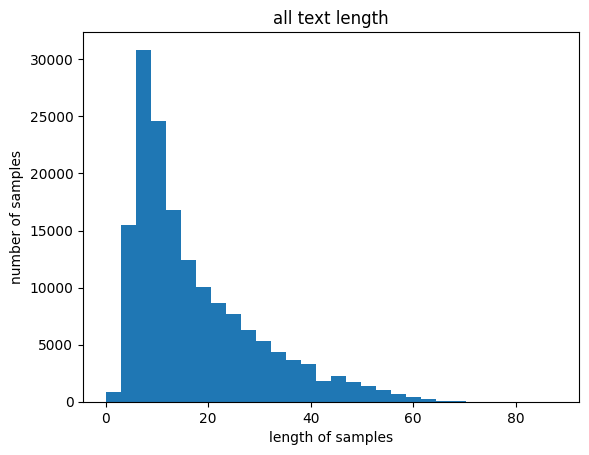

In [ ]:
import matplotlib.pyplot as plt

num_tokens = [len(review) for review in X_train]

plt.title('all text length')
plt.hist(num_tokens, bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9337005865212661


In [ ]:
# 최대 길이를 40으로 잡고 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
# model 변경 함수
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

#5. DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class LabeledNumpyArrayDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
        self.data = numpy_data
        self.labels = numpy_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [ ]:
batch_size = 64

# 레이블링된 데이터셋 객체 생성
train_dataset = LabeledNumpyArrayDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LabeledNumpyArrayDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 6. Modeling(Vanilla RNN)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)
        out, h0 = self.rnn(embedded, h0.detach())

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :] # (batch_size, hidden_dim) size

        """
        문제 1: 이제 out을 우리가 원하는 output_dim 차원으로 변환해주어야 합니다.
        빈칸에 들어갈 인스턴스 변수를 채워넣어주세요.
        """
        out = self.fc(out)
        return out


In [ ]:
import torch
import torch.nn as nn

num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

"""
문제 2: RNN에서 loss를 계산하는 기준은 무엇일까요? 빈칸에 알맞은 답을 적어주세요
"""
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        """
        문제 2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.
        """
        loss = criterion(logits, labels)

        loss.backward()

        """
        문제 3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.
        """
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


Iteration: 500. Loss: 0.2940143644809723. Accuracy: 85.00575256347656
Iteration: 1000. Loss: 0.3066334128379822. Accuracy: 88.25221252441406
Iteration: 1500. Loss: 0.3529684543609619. Accuracy: 87.06417846679688
Iteration: 2000. Loss: 0.4379046559333801. Accuracy: 86.60647583007812
Iteration: 2500. Loss: 0.2814885377883911. Accuracy: 89.2076416015625
Iteration: 3000. Loss: 0.36135372519493103. Accuracy: 87.80451202392578
Iteration: 3500. Loss: 0.4878929853439331. Accuracy: 85.72357940673828
Iteration: 4000. Loss: 0.40394577383995056. Accuracy: 86.97663879394531
Iteration: 4500. Loss: 0.32929593324661255. Accuracy: 87.5919189453125
Iteration: 5000. Loss: 0.1687924712896347. Accuracy: 86.656494140625
Iteration: 5500. Loss: 0.4571681618690491. Accuracy: 88.77745056152344
Iteration: 6000. Loss: 0.2644188106060028. Accuracy: 87.63443756103516
Iteration: 6500. Loss: 0.41428342461586. Accuracy: 88.21969604492188
Iteration: 7000. Loss: 0.22800450026988983. Accuracy: 88.81246948242188
Iteration

# 6. Modeling(LSTM)


In [ ]:
class LSTMModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # 초기에 cell state를 영행렬로 초기화
        c0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(embedded, (h0.detach(), c0.detach()))

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :]

        # fc layer를 통해 (batch_size, output_dim)로 차원을 변경해줍니다.
        out = self.fc(out)

        return out

In [ ]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
  iter = 0
  for epoch in range(num_epoch):
      for i, (text, labels) in enumerate(train_dataloader):
          model.train()

          text = text.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          logits = model(text).to(device)

          loss = criterion(logits, labels)
          loss.backward()

          # Updating parameters
          optimizer.step()

          iter += 1

          if iter % 1000 == 0:
              model.eval()
              # Calculate Accuracy
              correct = 0
              total = 0
              # Iterate through test dataset
              for test_text, test_labels in test_dataloader:
                  test_text = test_text.to(device)
                  test_labels = test_labels.to(device)
                  # Forward pass only to get logits/output
                  outputs = model(test_text)

                  # Get predictions from the maximum value
                  _, predicted = torch.max(outputs.data, 1)

                  # Total number of labels
                  total += test_labels.size(0)

                  # Total correct predictions
                  correct += (predicted == test_labels).sum()

              accuracy = 100 * correct / total

              # Print Loss
              print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.2787383198738098. Accuracy: 90.99845123291016
Iteration: 2000. Loss: 0.14265617728233337. Accuracy: 91.77629852294922
Iteration: 3000. Loss: 0.13099969923496246. Accuracy: 91.59871673583984
Iteration: 4000. Loss: 0.10880540311336517. Accuracy: 91.768798828125
Iteration: 5000. Loss: 0.20496438443660736. Accuracy: 92.10144805908203
Iteration: 6000. Loss: 0.16208603978157043. Accuracy: 91.67124938964844
Iteration: 7000. Loss: 0.17039620876312256. Accuracy: 91.59871673583984
Iteration: 8000. Loss: 0.0542680025100708. Accuracy: 91.44114685058594
Iteration: 9000. Loss: 0.1896422952413559. Accuracy: 91.58121490478516
Iteration: 10000. Loss: 0.04433505982160568. Accuracy: 91.17102813720703
Iteration: 11000. Loss: 0.09804697334766388. Accuracy: 91.03596496582031
Iteration: 12000. Loss: 0.24817228317260742. Accuracy: 91.24356079101562
Iteration: 13000. Loss: 0.12793996930122375. Accuracy: 91.16602325439453
Iteration: 14000. Loss: 0.052757371217012405. Accuracy: 91.251060

# 6. Modeling(GRU)


In [ ]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [ ]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [ ]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.1969246119260788. Accuracy: 90.90840911865234
Iteration: 2000. Loss: 0.16726237535476685. Accuracy: 91.64874267578125
Iteration: 3000. Loss: 0.26919126510620117. Accuracy: 91.23855590820312
Iteration: 4000. Loss: 0.19021904468536377. Accuracy: 91.65874481201172
Iteration: 5000. Loss: 0.17034539580345154. Accuracy: 91.67875671386719
Iteration: 6000. Loss: 0.15050581097602844. Accuracy: 91.58871459960938
Iteration: 7000. Loss: 0.17357982695102692. Accuracy: 91.3761215209961
Iteration: 8000. Loss: 0.13312923908233643. Accuracy: 91.2535629272461
Iteration: 9000. Loss: 0.1503594070672989. Accuracy: 91.34610748291016
Iteration: 10000. Loss: 0.08150852471590042. Accuracy: 91.38862609863281
Iteration: 11000. Loss: 0.161854550242424. Accuracy: 91.09349060058594
Iteration: 12000. Loss: 0.05807682126760483. Accuracy: 91.22855377197266
Iteration: 13000. Loss: 0.13300858438014984. Accuracy: 91.03846740722656
Iteration: 14000. Loss: 0.13059744238853455. Accuracy: 90.91841125

# 7. Evaluation

- Accuracy: LSTM > GRU > Vanilla RNN
  - Vanilla RNN: 0.88
  - LSTM: 0.92
  - GRU: 0.90
- 근거: LSTM과 GRU의 경우 RNN에서 장기의존성 문제를 해결하기 위해 고안된 모델이기에 더 나은 성능을 보이는 것으로 추정된다.
